# How to Fit Grid Models to Data

In this notebook, we show how to use the `PICASO`-formatted grid models to interpret data. We will use the results of the [JWST Transiting Exoplanet Community Early Release Science Team's](https://arxiv.org/pdf/2208.11692.pdf) first look analysis of WASP-39 b.

**Helpful knowledge before running this notebook:**

- [How to use xarray files](https://natashabatalha.github.io/picaso/notebooks/codehelp/data_uniformity_tutorial.html) 
- [Basic PICASO knowledge of how to compute transit spectra](https://natashabatalha.github.io/picaso/notebooks/workshops/ESO2021/ESO_Tutorial.html)

**Need to do before running this notebook**

In order to use this notebook you will have to: 

- [Download and unpack the zenodo grid models](https://doi.org/10.5281/zenodo.7236759)
- [Download the final planet spectrum](https://zenodo.org/record/6959427#.Y1M0U-zMLvU) 

In [1]:
import numpy as np
import os

import picaso.justdoit as jdi
import picaso.justplotit as jpi
import picaso.analyze as lyz
jpi.output_notebook()

Loading BokehJS ...

## Define Paths To Data and Models

You should have four folders in your `model_dir`: 

1. `RCTE_cloud_free/`: 192 models 
2. `RCTE_cloudy/`: 3840 models 
3. `photochem_cloud_free/`: 116 models
4. `photochem_cloudy/`: 580 models 


In [2]:
#should have sub folders similar to above
#agnostic to where it is, just make sure you point to the right data file
model_dir = "../picaso_data/models/WASP-39b/xarray/" # model_dir = "/data2/models/WASP-39B/xarray/"

#downloaded and unzipped from Zenodo
data_dir = '../picaso_data/observations/WASP-39b/ZENODO/TRANSMISSION_SPECTRA_DATA/' # data_dir = '/data2/observations/WASP-39b/ZENODO/TRANSMISSION_SPECTRA_DATA/'
#for this tutorial let's grab the firely reduction
data_file = os.path.join(data_dir,"FIREFLY_REDUCTION.txt")

##### unpack wavelength grid center values, transit depths, wavelength bin widths, transit depth errors
wlgrid_center,rprs_data2,wlgrid_width,e_rprs2 = np.loadtxt(data_file,usecols=[0,1,2,3],unpack=True,skiprows=1)

#for now, we are only going to fit 3-5 um
##### find where wavelength centers are less than 3 microns, then remove those indices from the other arrays
wh =  np.where(wlgrid_center < 3.0)
wlgrid_center = np.delete(wlgrid_center,wh[0])
wlgrid_width = np.delete(wlgrid_width,wh[0])
rprs_data2 = np.delete(rprs_data2,wh[0])
e_rprs2 = np.delete(e_rprs2,wh[0])
reduction_name = "Firefly"

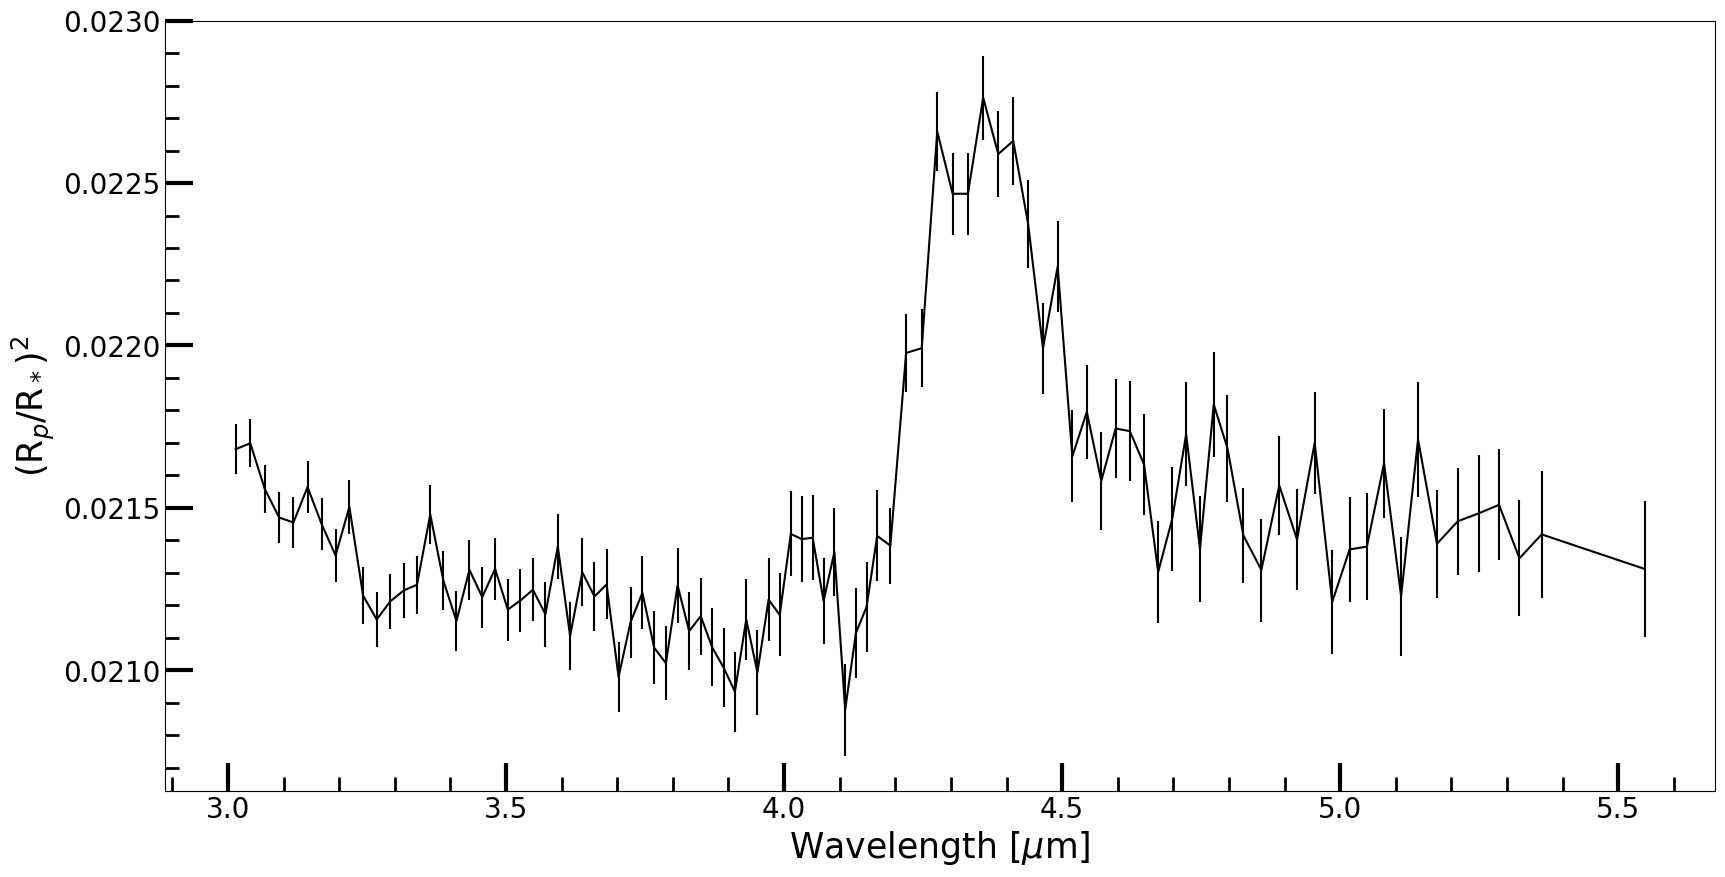

In [3]:
f=jpi.plot_errorbar(wlgrid_center,rprs_data2,e_rprs2,plot_type='matplotlib',
                   plot_kwargs={'ylabel':r'(R$_p$/R$_*$)$^2$'})#plot_type='bokeh' also available
#jpi.show(f) #if using bokeh (note if using bokeh need those key words (e.g. y_axis_label instead of ylabel))

## Add Available Grids to Test

First step will be to load your first grid into the `GridFitter` class. You can do this easily by supplying the function a directory location and grid name (`grid_name`). 

The only purpose of `grid_name` is in case you add more grids to your `GridFitter` function, it will be easy to keep track of what parameters go with what grid.  

In [4]:
grid_name = "picaso_cld_free"
location = os.path.join(model_dir,"RCTE_cloud_free")
fitter = lyz.GridFitter(grid_name,location,verbose=True)

Total number of models in grid is 192
For tint in planet_params grid is: [100. 200. 300.]
For heat_redis in planet_params grid is: [0.4 0.5]
For mh in planet_params grid is: [  0.1     0.316   1.      3.162  10.     31.623  50.119 100.   ]
For cto in planet_params grid is: [0.229 0.458 0.687 0.916]


This shows you what parameters the grid was created over

In [5]:
fitter.grid_params['picaso_cld_free']['planet_params'].keys()

dict_keys(['tint', 'heat_redis', 'mh', 'cto'])

In [6]:
location = os.path.join(model_dir,"RCTE_cloudy")
fitter.add_grid('picaso_cldy',location)

Total number of models in grid is 3840
For tint in planet_params grid is: [100. 200. 300.]
For heat_redis in planet_params grid is: [0.4 0.5]
For logkzz in planet_params grid is: [ 5.  7.  9. 11.]
For mh in planet_params grid is: [  0.1     0.316   1.      3.162  10.     31.623  50.119 100.   ]
For cto in planet_params grid is: [0.229 0.458 0.687 0.916]
For fsed in cld_params grid is: [ 0.6  1.   3.   6.  10. ]


### Explore the parameters of the grid

You can see what grids you have loaded

In [7]:
fitter.grids #what grids exist

['picaso_cld_free', 'picaso_cldy']

You can also see what the top level information about your grid is

In [8]:
fitter.overview['picaso_cld_free'] #top level info from the attrs 

{'planet_params': {'rp': 1.279,
  'mp': 0.28,
  'tint': array([100., 200., 300.]),
  'heat_redis': array([0.4, 0.5]),
  'p_reference': 10.0,
  'logkzz': 'Not used in grid.',
  'kzz': nan,
  'mh': array([  0.1  ,   0.316,   1.   ,   3.162,  10.   ,  31.623,  50.119,
         100.   ]),
  'cto': array([0.229, 0.458, 0.687, 0.916]),
  'p_quench': 'Not used in grid.',
  'rainout': 'Not used in grid.',
  'teff': nan,
  'logg': nan,
  'gravity': nan,
  'm_length': nan},
 'stellar_params': {'rs': 0.932,
  'logg': 4.38933,
  'steff': 5326.6,
  'feh': -0.03,
  'ms': 0.913},
 'cld_params': {'opd': 'Not used in grid.',
  'ssa': 'Not used in grid.',
  'asy': 'Not used in grid.',
  'p_cloud': 'Not used in grid.',
  'haze_eff': nan,
  'fsed': 'Not used in grid.'},
 'num_params': 4}

The full list of planet parameters can also be cross referenced against the full list of file names so you can easily plot of different models. 

<div class="alert alert-block alert-info">
What does this next cell do?
</div>

In [9]:
#this tells you the internal temperature of the 0th file in picaso_cld_free (grabbed from the xarray)
print(fitter.grid_params['picaso_cld_free']['planet_params']['tint'][0], 
#this full list can be cross referened against the file list 
fitter.list_of_files['picaso_cld_free'][0])
#in this case we can verify against the filename (tint 100 --> planet_100)

100.0 ../picaso_data/models/WASP-39b/xarray/RCTE_cloud_free/profile_eq_planet_100_grav_4.5_mh_+1.5_CO_0.5_sm_0.0486_v_0.4_.nc


## Add Datasets to Explore

Though the models are interesting, what we are really after is which is most representative of the data. So now let's add some datasets to explore. 

In [10]:
fitter.add_data('firefly',wlgrid_center,wlgrid_width,rprs_data2,e_rprs2)

## Compute $\chi_{red}^2$/N and Retrieve Single Best Fit

In this analysis we used the reduced chi sq per data point as a metric to fit the grid. This fitter function will go through your whole grid and compute cross reference the chi sq compared to your data. 

In [11]:
fitter.fit_grid('picaso_cld_free','firefly')
fitter.fit_grid('picaso_cldy','firefly')

Now that we have accumulated results let's turn this into a dictionary to easily see what we've done

In [12]:
out = fitter.as_dict() #allows you to easily grab data
out.keys()

dict_keys(['list_of_files', 'spectra_w_offset', 'rank_order', 'grid_params', 'offsets', 'chi_sqs', 'posteriors'])

In [13]:
##### REWA #####
#We couldn't figure out what rank_order really is...

#does rank_order find which index the lowest chi_sq occurs at?
print('rank 0 occurs at index:', np.where(out['rank_order']['picaso_cld_free']['firefly'] == 0))

#print the chi_sq value at that index
print('chi-sq of rank 0:', out['chi_sqs']['picaso_cld_free']['firefly'][46])

#is this actually the min chi_sq value? --> no. weird.
print('min chi-sq:', min(out['chi_sqs']['picaso_cld_free']['firefly']))

#this is an array of all the mh values for each model in the picaso_cld_free grid
print(out['grid_params']['picaso_cld_free']['planet_params']['mh'])

#this rearranges the previous array in the rank order determined after fitting the model to firefly data
np.array(out['grid_params']['picaso_cld_free']['planet_params']['mh']
        )[out['rank_order']['picaso_cld_free']['firefly']]

#but do we trust it??

rank 0 occurs at index: (array([46]),)
chi-sq of rank 0: 4.4243237229982455
min chi-sq: 1.9198756667276047
[ 31.623  31.623   0.316  10.     10.     10.     10.      0.316  31.623
  31.623 100.    100.      3.162  50.119  50.119   3.162   0.1     1.
   1.      1.      1.      0.1     3.162  50.119  50.119   3.162 100.
 100.     10.     10.      0.316   0.316  10.     10.      0.1     3.162
  50.119  50.119   3.162 100.    100.    100.    100.      3.162  50.119
  50.119   3.162   0.1     0.316  31.623  31.623   0.316  10.     10.
   0.316  31.623  31.623   0.316   3.162   0.1     1.      1.      0.1
  50.119 100.    100.     50.119   0.1     1.      1.      0.1     3.162
  31.623  31.623  10.      0.316   0.316   0.316   0.316  10.     31.623
  31.623 100.     50.119   0.1     0.1     3.162   1.      1.      1.
   1.      3.162   0.1     0.1    50.119 100.      3.162  50.119   0.1
   3.162   0.1    50.119   1.    100.    100.    100.    100.      1.
   0.1    50.119   3.162  50.119   0

array([100.   , 100.   , 100.   , 100.   , 100.   , 100.   , 100.   ,
       100.   , 100.   , 100.   , 100.   , 100.   , 100.   , 100.   ,
       100.   , 100.   , 100.   , 100.   ,  50.119,  50.119,  50.119,
        31.623,  50.119,  31.623,  50.119,  50.119,  31.623,  50.119,
        50.119,  50.119,  50.119,  50.119,  50.119,  50.119,  50.119,
        50.119,  50.119,  50.119,  50.119,  31.623,   3.162,   3.162,
         3.162,  31.623,   3.162,   3.162,  31.623,   3.162,   3.162,
        31.623,  31.623,   3.162,   3.162,  10.   ,  31.623,  10.   ,
        10.   ,  31.623,  10.   ,  31.623,  31.623,  10.   ,  10.   ,
        31.623,  31.623,  31.623,  31.623,  31.623,  10.   ,  10.   ,
        10.   ,  10.   ,   3.162,  10.   ,   3.162,  10.   ,  31.623,
         3.162,  10.   ,  10.   ,  10.   ,   3.162,   3.162,   3.162,
         1.   ,   1.   ,   1.   ,  10.   ,  10.   ,  10.   , 100.   ,
       100.   , 100.   ,   1.   ,   1.   ,   1.   , 100.   , 100.   ,
       100.   ,   1.

We are most interested in the models with the best reduced chi sq. We can use our ranked order to get the models that best fit the data. 

In [14]:
### Use rank order to get the top best fit or other parameters
#top 5 best fit models metallicities for the cloud free grid
print("cld free",np.array(out['grid_params']['picaso_cld_free']['planet_params']['mh']
        )[out['rank_order']['picaso_cld_free']['firefly']][0:5])

#top 5 best fit models metallicities for the cloudy grid
print("cldy",np.array(out['grid_params']['picaso_cldy']['planet_params']['mh']
        )[out['rank_order']['picaso_cldy']['firefly']][0:5])

cld free [100. 100. 100. 100. 100.]
cldy [ 3.162 10.    10.    10.    10.   ]


<div class="alert alert-block alert-info">
The first print statement in the cell above does the following:
    
1. Grabs the M/H values of the picaso_cld_free model from the fitter output and turns them into an array.
2. Reorders that array based on the ranked order of chi-sq values from the fitter output (relevant to the picaso_cld_free model and the firefly data reduction).
3. Takes just the first 5 values.
4. Prints "cld free" followed by the array of those metallicities associated with the top 5 chi-sq values.
</div>

Interesting! We are already seeing interesting information. Without clouds our model predicts higher metallicity than when we add clouds. Let's look at the associated chi square values. 

In [15]:
#top 5 best fit chi sqs for the cloud free grid
print("cld free", np.array(out['chi_sqs']['picaso_cld_free']['firefly']
        )[out['rank_order']['picaso_cld_free']['firefly']][0:5])
      
#top 5 best fit chi sq for the cloudy grid
print("cldy", np.array(out['chi_sqs']['picaso_cldy']['firefly']
        )[out['rank_order']['picaso_cldy']['firefly']][0:5])

cld free [1.91987567 1.92849109 1.9556125  2.00119925 2.01856747]
cldy [1.32818737 1.37253841 1.37564302 1.39244227 1.39555045]


The cloudy grid is giving lower chi square giving us clues that this planet likely has clouds affecting the spectrum.

## Analyze Single Best Fits

Let's analyze the single best fits in order to compare the spectrum with the data

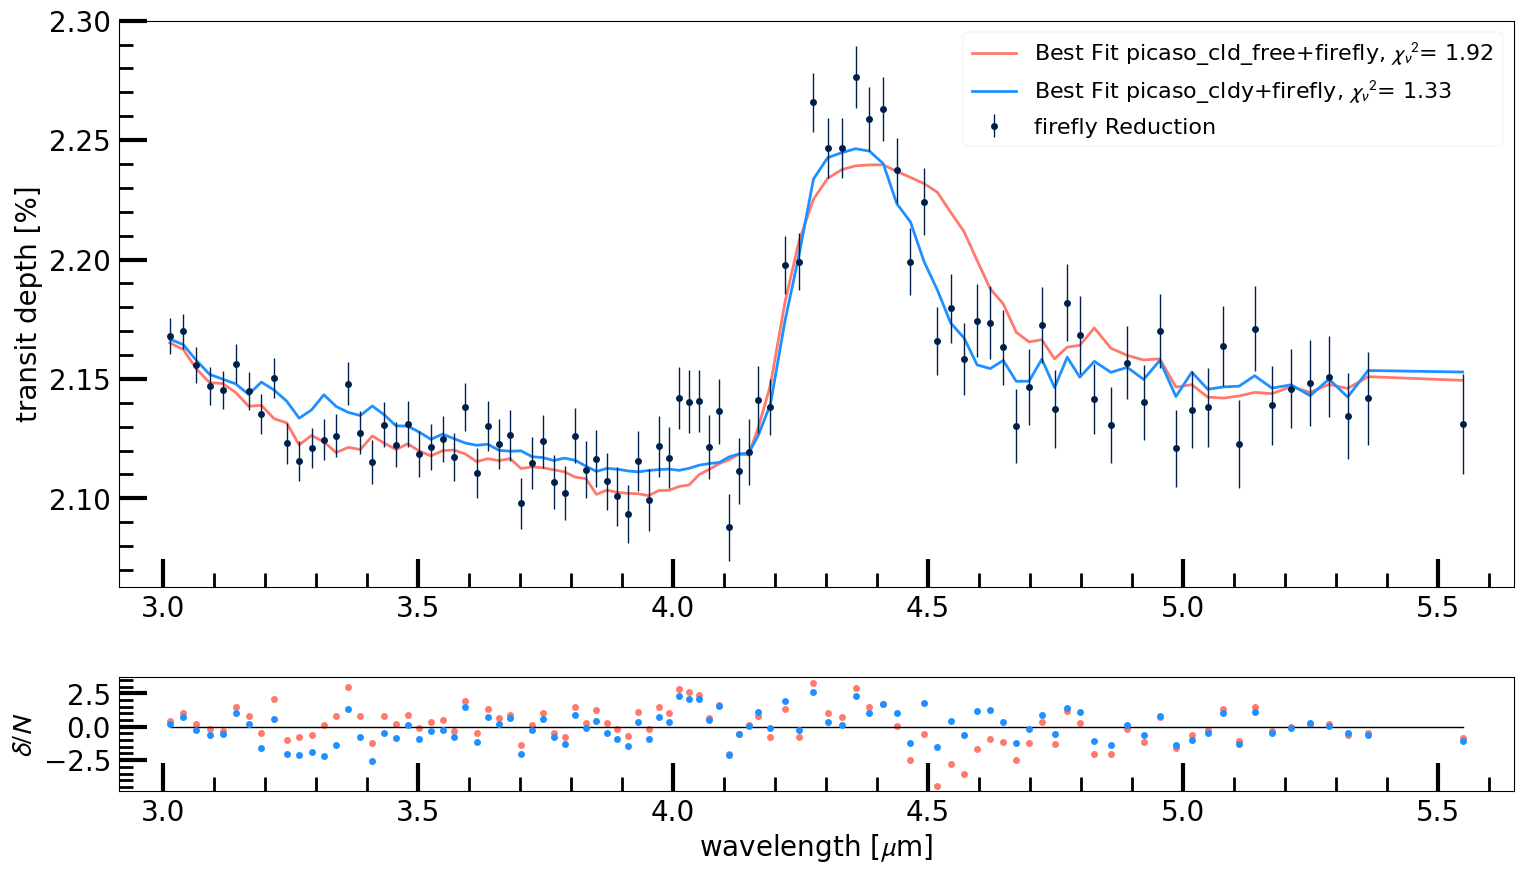

In [16]:
fig,ax = fitter.plot_best_fit(['picaso_cld_free','picaso_cldy'],'firefly')

By-eye, our cloudy grid is giving a much better representation of the data. Let's look at what physical parameters are associated with this. 

In [17]:
best_fit = fitter.print_best_fit('picaso_cldy','firefly')

tint=100.0
heat_redis=0.5
logkzz=9.0
mh=3.162
cto=0.458
fsed=0.6


You can see these same parameters reported in original Nature paper: https://arxiv.org/pdf/2208.11692.pdf

## Estimated Posteriors 

It is also helpful to get an idea of what the probability is for each grid parameter in your model. This will give you a better representation of degeneracies that exist with your data and each of your physical parameters. 

<div class="alert alert-block alert-info">
    
A posterior is a representation of the statistical likelihood that some parameter value is representative of your data. The higher the posterior likelihood (y-value), the more likely that x-value is to represent your data. This probabilistic value will not necessarily match the value associated with the best chi square model. Chi square gives you the single model that best fits the data, but doesn’t necessarily show how each parameter drives that fit.


There are two ways of reporting your fit:
- Grid fitting (this notebook): You can create a grid of all combinations of your parameters, then compare every model in the grid with your reduced data, and compute a chi square for each modelxdata combo. Then report the model with the best chi square value.
    - Next you can bin up the parameters based on chi square bin. Meaning, what values of MH are selected for by the best 10 chi square values, what values of MH are selected for by the next best 20 chi square values, etc. Then for each MH value, you can create a histogram of how likely that MH is going to give you a great chi square value. 
    - These are the plots below. They tell you, for a given MH value (say MH=100), how likely is this going to give you the best fit chi square value (in this case, 0.4). The higher the likelihood, the more confident you feel in that MH value.
    - However, these plots show you the overall likelihood that a given parameter value will result in a good chi square, which does not necessarily correspond to the parameter’s value in your best chi square model. Ex: The best cloudy model has mh=3.162, but the MH plot indicates mh=100 is the most likely optimal MH value for the cloudy model.
    - Because your grid only has a set number of parameters and thus a set number of models, this is only a “Estimated posterior.”
- Bayesian corner plot:
    - This gets you a “real posterior” because you let the sampler run freely over all possible parameter values and combinations.
    - You set a sampler (like UltraNest or MCMC) that tries combinations of values all across parameter space, roaming freely and randomly, until it creates a distribution of param values that give the best fit. The median of this distribution will be the value that best represents your data. You can expand out 1 sigma on either side of the media, and say you are 68% confident that the value falls within that range (this is your uncertainty).

</div>

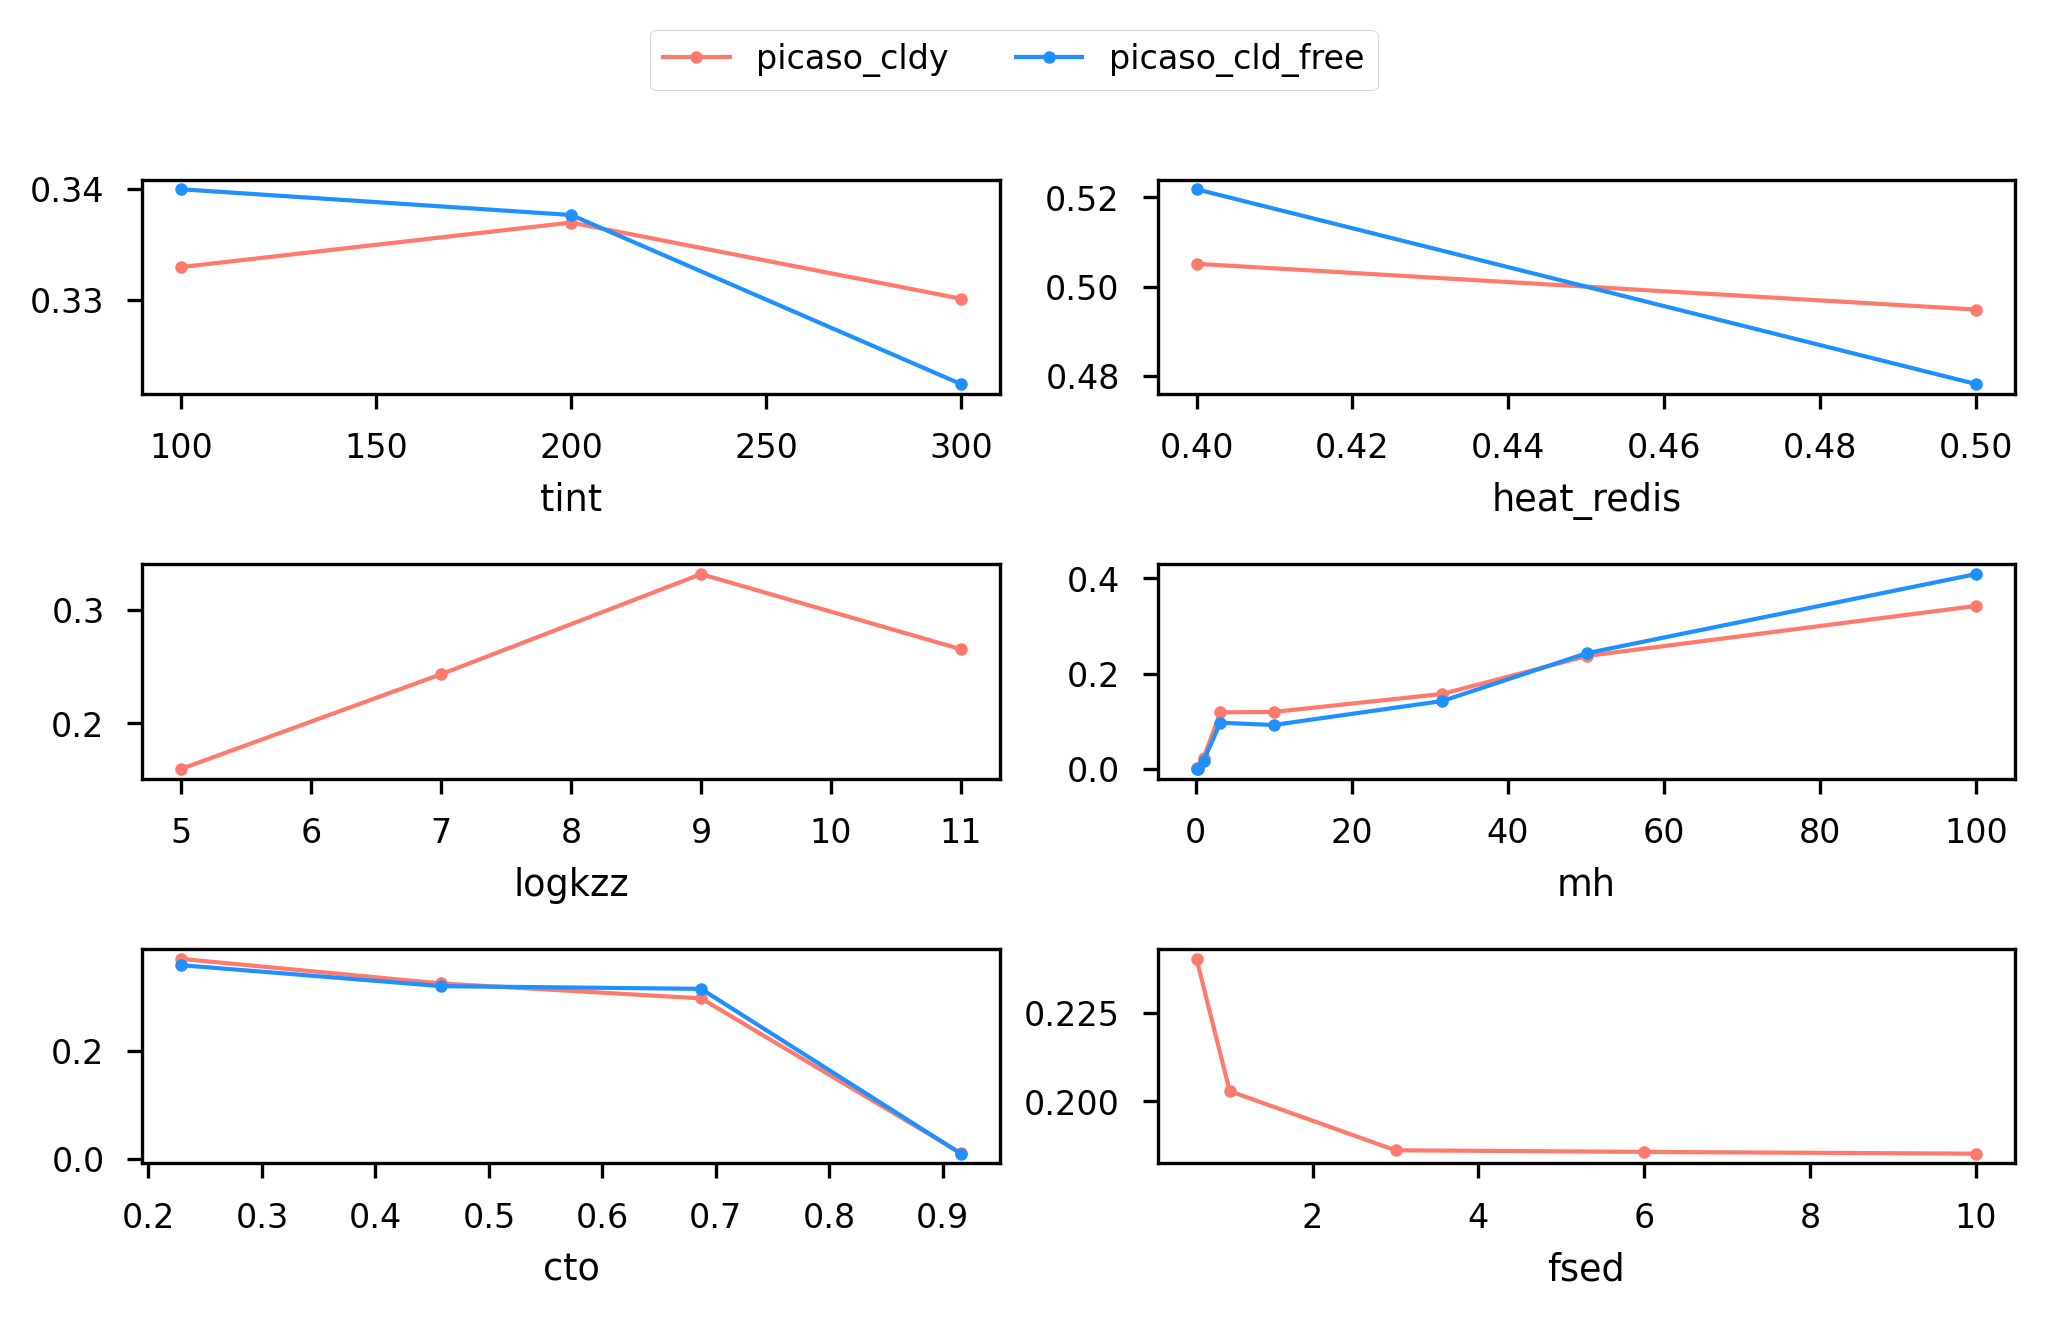

In [18]:
posterior_chance_dict, fig = fitter.plot_chi_posteriors(['picaso_cldy','picaso_cld_free'], 
                                                        'firefly',max_row=3,max_col=2,input_parameters='all')

In [19]:
posterior_chance_dict

{'picaso_cldy': {'tint': {'100.0'},
  'heat_redis': {'0.4'},
  'logkzz': {'9.0'},
  'mh': {'100.0'},
  'cto': {'0.229'},
  'fsed': {'0.6'}},
 'picaso_cld_free': {'tint': {'100.0'},
  'heat_redis': {'0.4'},
  'logkzz': {'9.0'},
  'mh': {'100.0'},
  'cto': {'0.229'},
  'fsed': {'0.6'}}}

What can you take away from this plot? 
1. Cloudy models reduce the number of models that can be fit to the data with high metallicity
2. Internal temperature cannot be constrained by the data 
3. C/O ratios greater than ~0.8 can be ruled out by the data

<div class="alert alert-block alert-info">

Let’s assess different estimated posterior plots above.

- mh: Metallicity MH is related to mean molecular weight. We know that higher mean molecular weight means a smaller atmospheric scale height, which squishes the spectral features. We also know clouds will squish the spectral features by raising their bottom by creating an optically thick layer. Thus MH and clouds are difficult to disentangle. We saw from the overall chi square grid fitter that clouds are favored because the cldy model results in a lower chi_sqs. We see in these posterior plots that when you add clouds, the probability that your atmosphere has high MH goes up, and the probability that you have low MH goes down. Thus adding clouds effectively reduced the number of high MH models that gave a good fit. 
- tint: We saw without clouds (blue) low tints are preferred. But with clouds (salmon), there is not a big preference for low vs high tints. Therefore we conclude that internal temperatures cannot be used to constrain the data.
- cto: There are basically no models with c/o of 0.9 that result in good chi square values (0 probability), so we can rule out c/o > 0.8. With and without clouds we get the same c/o estimates, so we conclude that the c/o ratio is not dependent on clouds.

Overall, we find that adding clouds improves the best overall chi_sqs value, and changes the estimated posteriors (e.g. clouds impact the probable value of mh). Thus we conclude we should include clouds in the model, because they impact the overall fit.

    
</div>

## Interpret Best Fit

Now that we are happy with the best-fitting model, we can load in that data and post process some plots in order to gain better understanding of our results.

We can use `PICASO`'s `xarray` loader to quickly load in one of our models. 

<div class="alert alert-block alert-info">
Breaking down the code below, so I understand the order of operations in finding and grabbing the top model...
    
<code>out['list_of_files']['picaso_cldy']</code>
This produces an array listing all filenames in the RCTE_cloudy directory.

<code>out['rank_order']</code>
This produces a dictionary with keys cld_free and cldy. For each key (cld_free or cldy), the value is another dictionary with key 'firefly', where the dict value is an array which gives the ranking for each file (e.g. [159, 125, 104, 144, etc.]).

<code>out['rank_order']['picaso_cldy']</code>
This selects just the cldy sub-dictionary in the rank_order dictionary. The result is a dictionary with key 'firefly' where the dict value is an array giving the ranking for each file in cldy (e.g. [436, 3468, etc.]).

<code>out['rank_order']['picaso_cldy']['firefly']</code>
This grabs just the dict value associated with key 'firefly', which is an array of the ranking of each file in cldyXfirefly. If a different data reduction was used instead of firefly, you could select for that here.

<code>np.array(out['list_of_files']['picaso_cldy'])[out['rank_order']['picaso_cldy']['firefly']]</code>
This takes the array of all the filenames of files in cldy(Xfirefly) and reorders them by rank.

<code>np.array(out['list_of_files']['picaso_cldy'])[out['rank_order']['picaso_cldy']['firefly']][0]</code>
This pulls the 0th filename from the array.
</div>

In [20]:
#grab top model 
top_model_file  = np.array(out['list_of_files']['picaso_cldy']
        )[out['rank_order']['picaso_cldy']['firefly']][0]

xr_usr = jdi.xr.load_dataset(top_model_file)
#take a look at the Xarray file 
xr_usr

<xarray.Dataset> Size: 606kB
Dimensions:                         (pressure: 91, wavelength: 8988,
                                     pressure_cld: 90, wno_cld: 196)
Coordinates:
  * pressure                        (pressure) float64 728B 1e-06 ... 1.8e+03
  * wavelength                      (wavelength) float64 72kB 6.0 ... 0.3001
  * pressure_cld                    (pressure_cld) float64 720B 1.118e-06 ......
  * wno_cld                         (wno_cld) float64 2kB 43.95 ... 3.731e+04
Data variables: (12/54)
    opd                             (pressure_cld, wno_cld) float64 141kB 1.1...
    ssa                             (pressure_cld, wno_cld) float64 141kB 4.6...
    asy                             (pressure_cld, wno_cld) float64 141kB 9.4...
    condensate_mmr_Na2S             (pressure_cld) float64 720B 0.0 0.0 ... 0.0
    condensate_plus_gas_mmr_Na2S    (pressure_cld) float64 720B 0.0001185 ......
    mean_particle_r_Na2S            (pressure_cld) float64 720B 0.0 0.0 ... 0.0
    ...                              ...
    OCS                             (pressure) float64 728B 8.033e-09 ... 7.5...
    Li                              (pressure) float64 728B 7.679e-12 ... 6.1...
    LiOH                            (pressure) float64 728B 4.33e-10 ... 2.3e-09
    LiH                             (pressure) float64 728B 2.283e-15 ... 7.3...
    LiCl                            (pressure) float64 728B 6.089e-09 ... 4.2...
    transit_depth                   (wavelength) float64 72kB 0.02463 ... 0.0...
Attributes:
    author:          Sarah E. Moran
    contact:         semoran@lpl.arizona.edu
    code:            {"spectrum": "PICASO", "climate": "PICASO", "chemistry":...
    doi:             Mukherjee et al., submitted; Batalha et al., in prep
    planet_params:   {"rp": {"value": 1.279, "unit": "jupiterRad"}, "mp": {"v...
    stellar_params:  {"rs": {"value": 0.932, "unit": "solRad"}, "logg": 4.389...
    orbit_params:    {"sma": 0.0486}
    atmo_params:     {"mh": 0.5, "cto": 1.0}
    cld_params:      {"fsed": 0.6, "species": "Na2S, MnS, MgSiO3"}

In [21]:
opa = jdi.opannection(wave_range=[3,5])
case = jdi.input_xarray(xr_usr,opa)
#if you need to rerun your spectrum 
#out = case.spectrum(opa,calculation='transmisson')

### See Contribution From Each Molecule

One of the most common plots that was also used in the original paper is the "leave one out" method to see how each molecule is affecting our spectrum. 

In [22]:
#copy atmosphere before modifying and rerunning picaso
og_atmo = jdi.copy.deepcopy(case.inputs['atmosphere']['profile'])
#atmo
w,f,l =[],[],[]
for iex in ['CH4','H2O','CO2',None]:
    case.atmosphere(df=og_atmo, exclude_mol=iex, delim_whitespace=True)
    df= case.spectrum(opa, full_output=True, calculation='transmission') #note the new last key 
    wno, rprs2  = df['wavenumber'] , df['transit_depth']
    wno, rprs2 = jdi.mean_regrid(wno, rprs2, R=150)
    w +=[wno]
    f+=[rprs2]
    if iex==None: 
        leg='all'
    else: 
        leg = f'No {iex}'
    l+=[leg]
jpi.show(jpi.spectrum(w,f,legend=l))

## Quantify Molecular Detection using Gaussian Fitting


For very gaussian shaped molecules (like CO2 in this case), we can use a simple Gaussian fitting technique to quantify the significance of our detection. Note this ONLY works in cases where the shape of the molecule is gaussian with a single peak and well-shaped wings. 

IOPub message rate exceeded. 1 | ncall: 32792 | eff(%): 17.382 | loglstar:   -inf < -87.562 <    inf | logz: -101.051 +/-  0.158 | dlogz: 19.139 >  0.509                                             
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded. | ncall: 1227 | eff(%): 37.897 | loglstar:   -inf < -1713.284 <    inf | logz: -1720.093 +/-  0.115 | dlogz: 1270.118 >  0.509                                           
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

iter: 2556 | +500 | boun

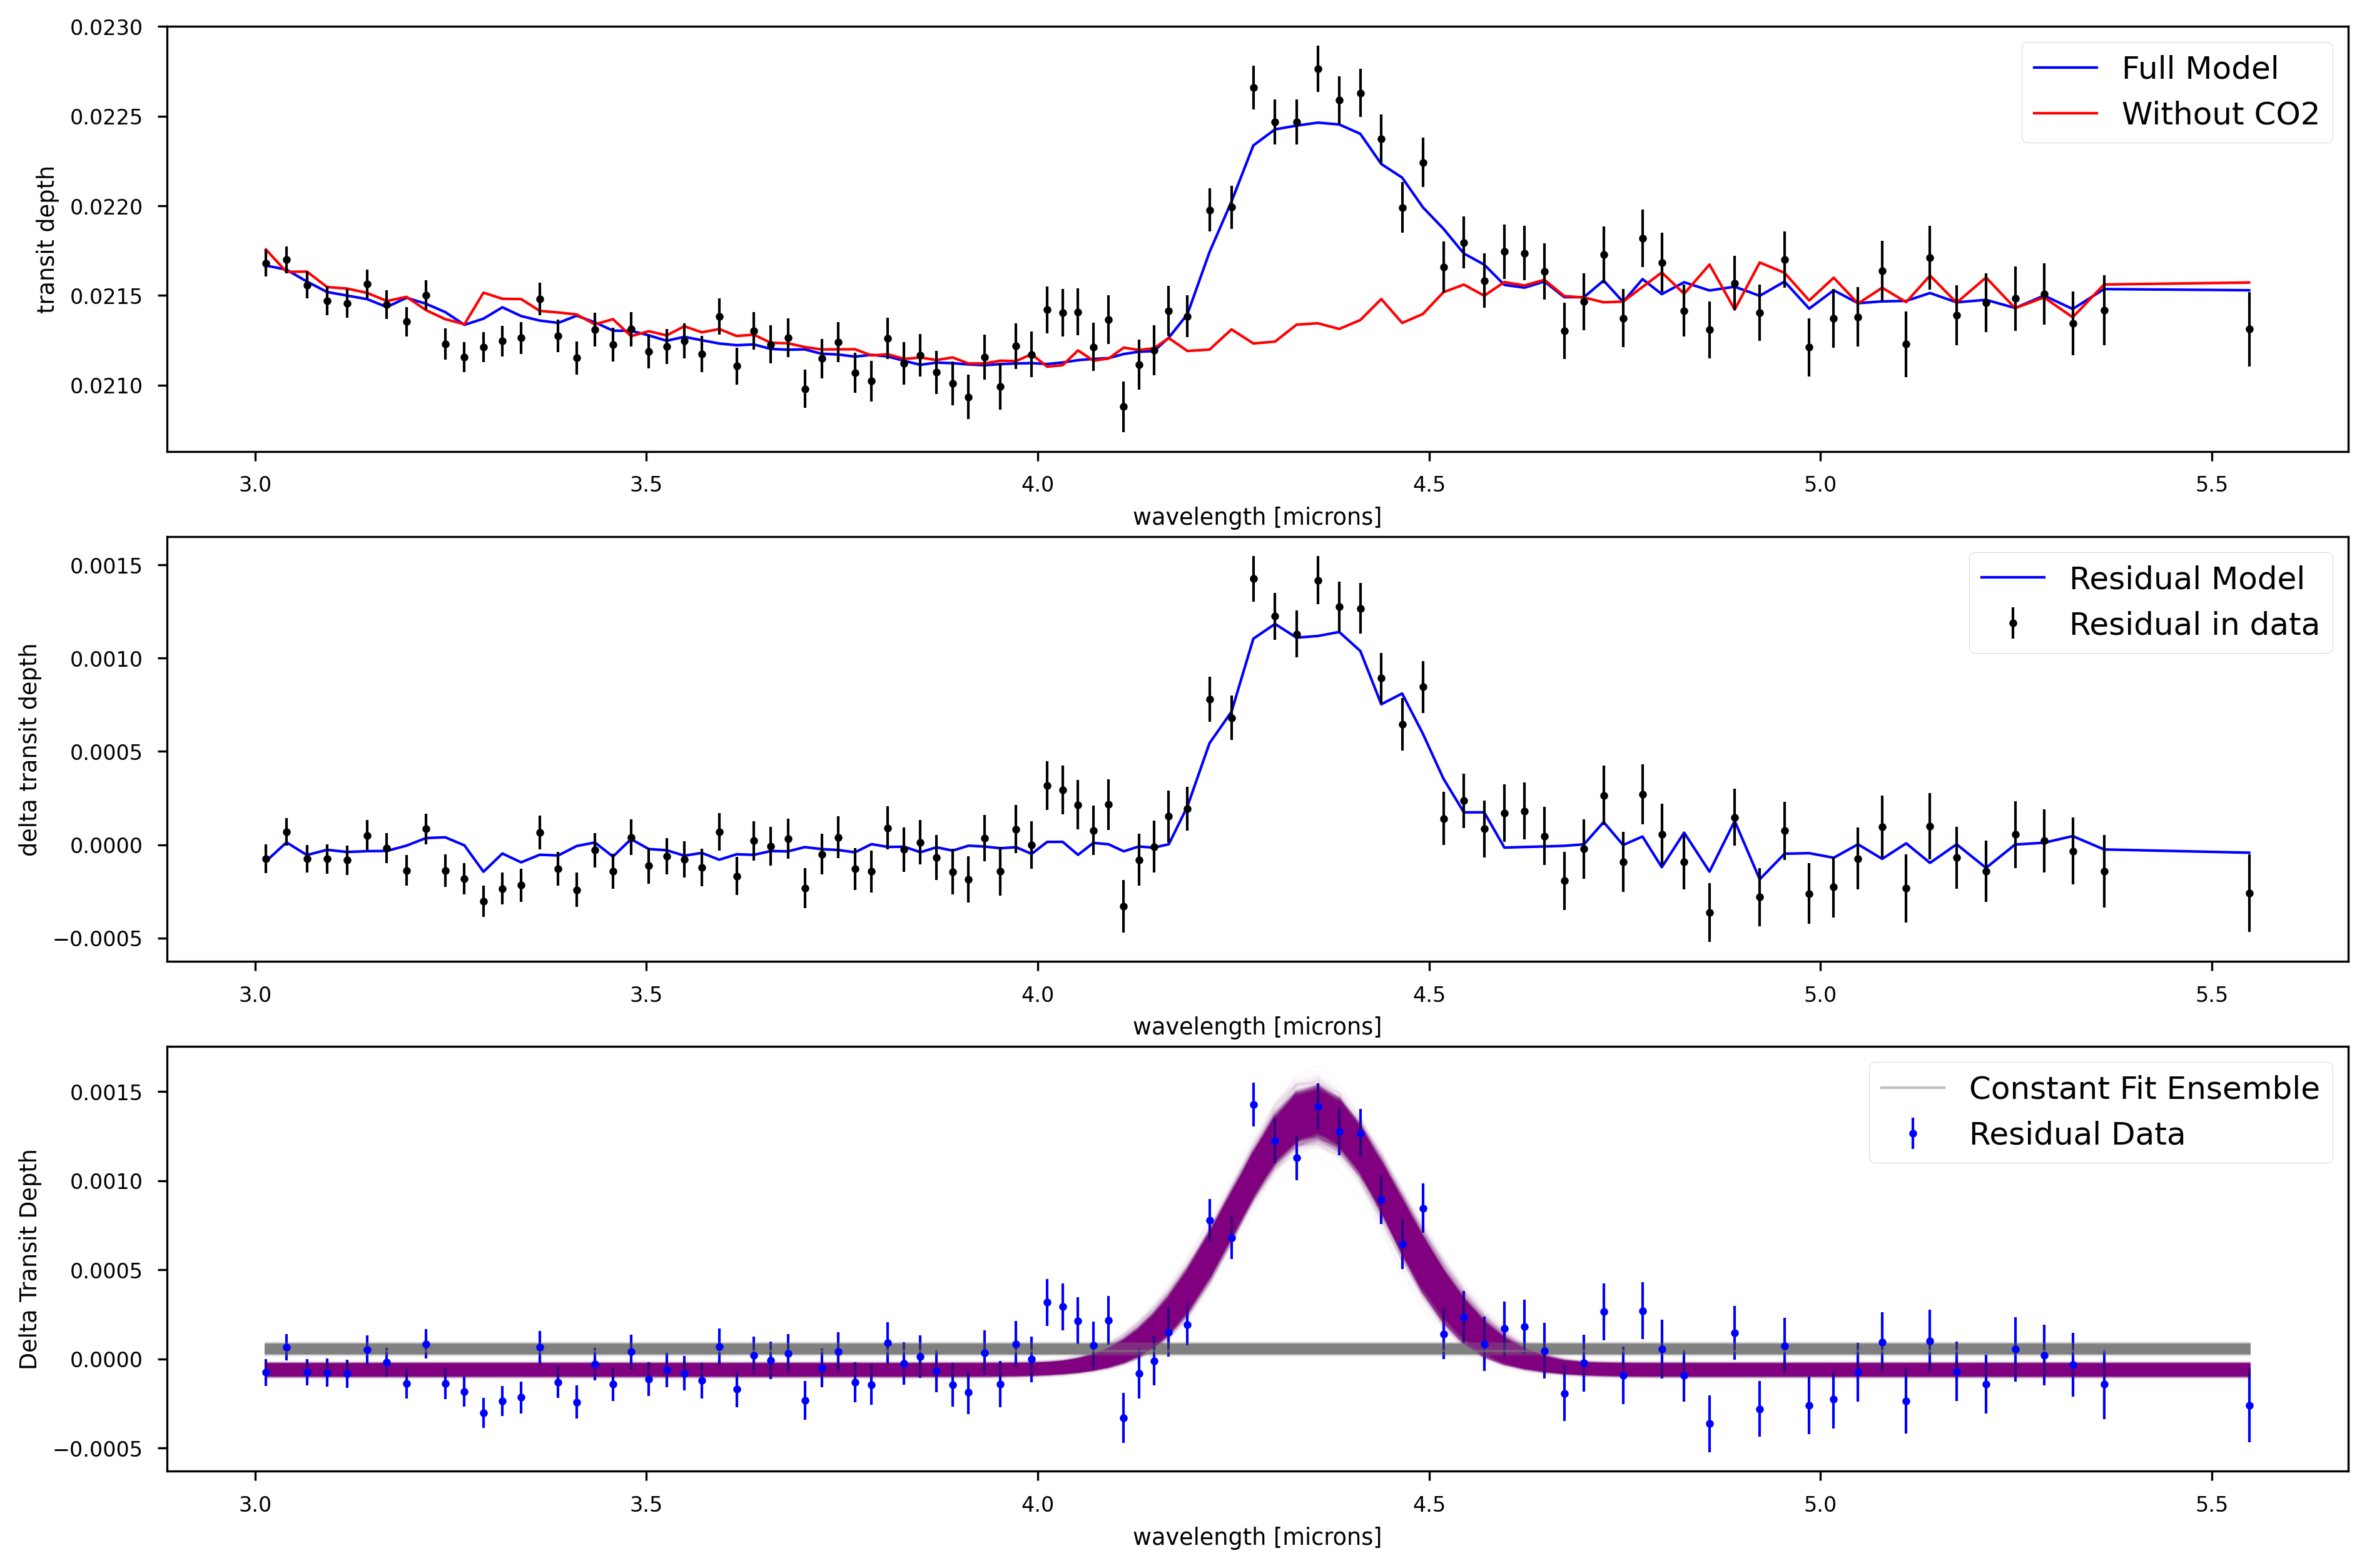

In [23]:
#grab file to test 
top_model_file  = np.array(out['list_of_files']['picaso_cldy']
        )[out['rank_order']['picaso_cldy']['firefly']][0]

min_wave = 3 #min wave to search for gauss peak
max_wave = 5 #max wave to search for gauss peak
out = lyz.detection_test(fitter,'CO2',min_wave,max_wave,'picaso_cldy','firefly',
                     top_model_file,
                     #opa_kwargs={wave_range=[]}#this is where you input arguments for opannection
                     plot=True)

By comparing the line fit to the single Gaussian fit, we can use the methodology of [Trotta 2008](https://ui.adsabs.harvard.edu/abs/2008ConPh..49...71T/abstract) to get out a sigma detection significance. In this case we can see that the single gaussian fit is preferred over the line model at 26 sigma.  

In [24]:
out['sigma_single_v_line']

27.264548999708598

<div class="alert alert-block alert-info">
    
If you report that you detected CO2, how confident are you? You need to quantify the significance. 

One (kind of janky) way is with a gaussian detection test (only works if your spectral feature has a roughly gaussian shape, like CO2):

1st plot: “Leave one out” |
Model the data using all possible molecules (get curvy spectrum), then model the data omitting CO2 (get flattish spectrum).

2nd plot: Subtraction |
Subtract the w/o CO2 model from the w/ CO2 model, getting rid of all the background molecule contributions. You’re left with residuals, which should just represent the CO2 contribution, if there is any. (see a curve if CO2 is present, a flat line if CO2 isn’t)

3rd plot: Fit the residuals with both a flat line (grey) and a gaussian (purple) and run dynasty (sampler) to test a bunch of such lines. With what confidence interval does the fitter prefer the purple gaussian (detection of CO2) over the grey line (non-detection of CO2). Since the residuals in this example show a big bump, that means the purples is favored with a huge sigma of certainty.

</div>